In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to convert the images to tensors
transform = transforms.ToTensor()

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='/data', train=True, transform=transform)
test_dataset = datasets.MNIST(root='/data', train=False, transform=transform)

# Access the data and labels
x_train = train_dataset.data
y_train = train_dataset.targets
x_test = test_dataset.data
y_test = test_dataset.targets

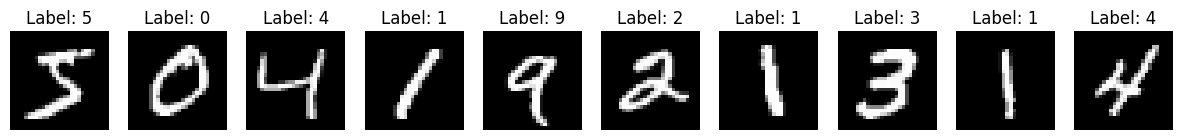

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 10, figsize=(15, 3))
for i in range(10):
    axs[i].imshow(x_train[i], cmap='gray')
    axs[i].set_title(f'Label: {y_train[i].item()}')
    axs[i].axis('off')

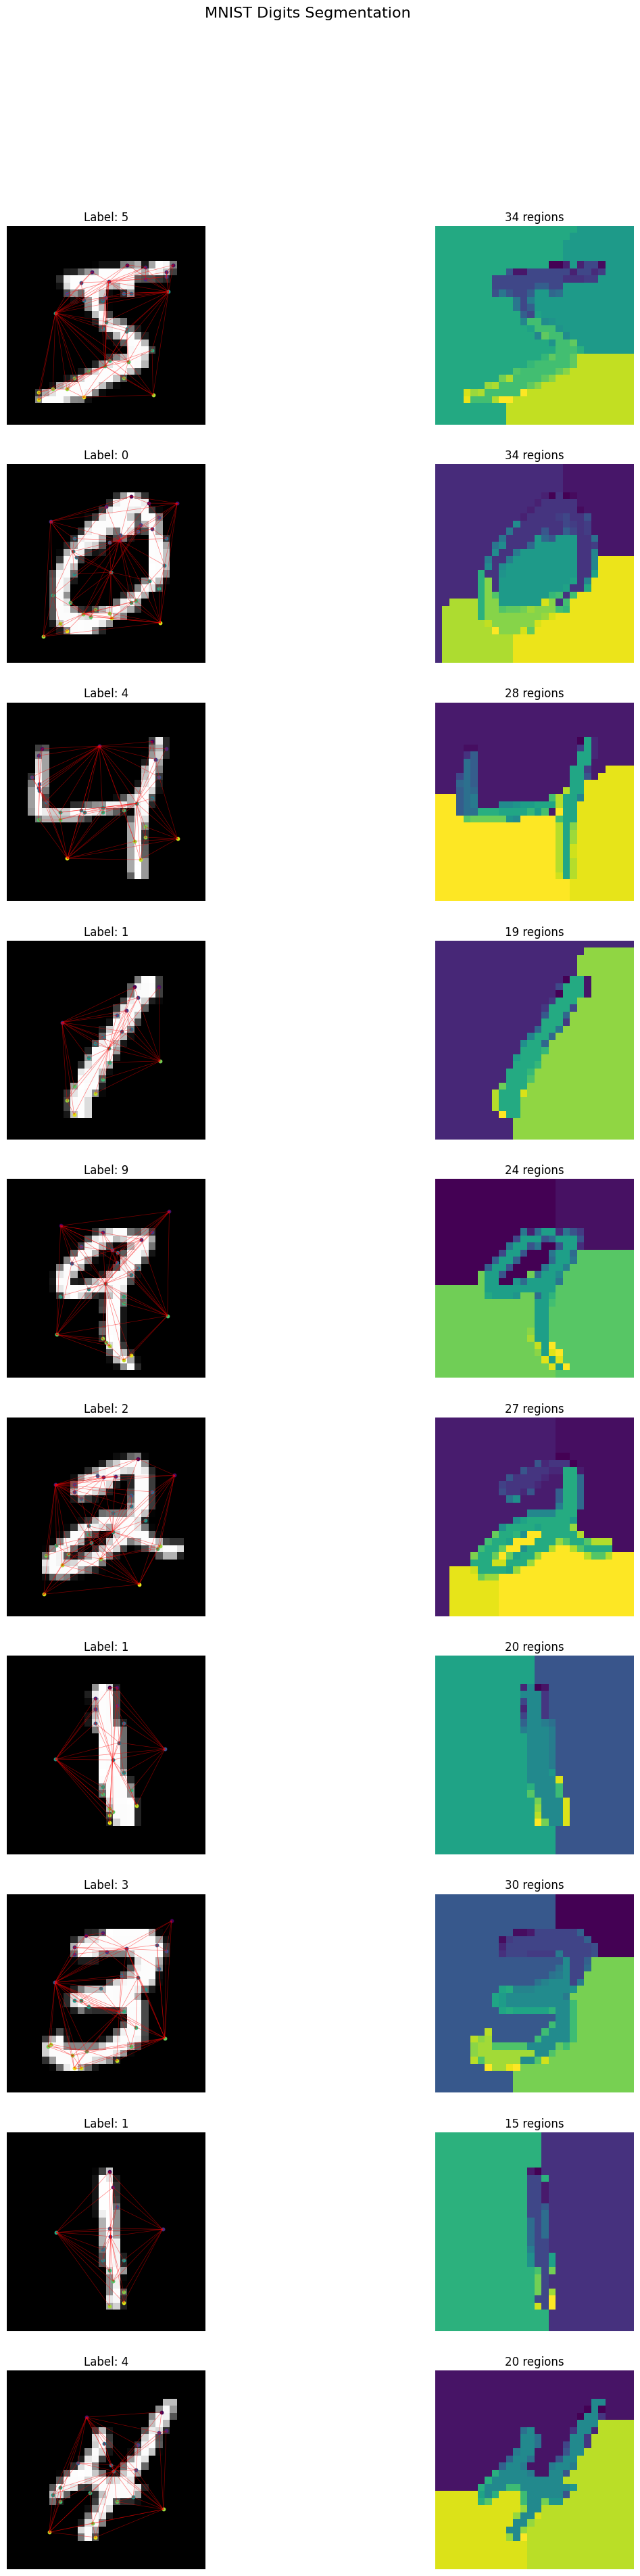

In [3]:
from skimage import segmentation as segm
import numpy as np
import skimage.graph as g
import networkx as nx
from pprint import pprint
from matplotlib.collections import LineCollection
from matplotlib import colormaps as cm
viridis = cm.get_cmap('viridis')

def find_centroid(segmented_image):
    """Find the centroid of each segment in the segmented image."""
    labels = np.unique(segmented_image)
    centroids = {}
    for label in labels:
        coords = np.column_stack(np.where(segmented_image == label))
        centroids[label] = coords.mean(axis=0)
    return centroids

fig, axs = plt.subplots(10, 2, figsize=(15, 45))
fig.text(0.5, 0.95, 'MNIST Digits Segmentation', ha='center', va='center', fontsize=16)
axs = axs.flatten()
for i in range(10):
    img = x_train[i].numpy()
    axs[2*i].imshow(img, cmap='gray')
    axs[2*i].set_title(f'Label: {y_train[i].item()}')
    axs[2*i].axis('off')
    
    segmented_image = segm.quickshift(np.stack([img]*3, axis=-1), kernel_size=3, max_dist=4, ratio=0.4)
    axs[2*i+1].imshow(segmented_image)
    axs[2*i+1].axis('off')
    axs[2*i+1].set_title(f'{len(np.unique(segmented_image))} regions')

    graph: g.RAG = g.rag_mean_color(np.stack([img]*3, axis=-1), segmented_image, mode='similarity')


    for n in graph.nodes:
        graph.nodes[n]['centroid'] = find_centroid(segmented_image)[n]
        color=viridis(graph.nodes[n]["labels"][0]/len(graph.nodes))
        axs[2*i].scatter(*graph.nodes[n]['centroid'][::-1], color=color, s=10)

    edges = list(graph.edges(data=True))
    for j in range(len(edges)):
        n1, n2, data = edges[j]
        start = graph.nodes[n1]['centroid']
        end = graph.nodes[n2]['centroid']
        assert len(start) == 2 and len(end) == 2, f"Centroid for node {n1} or {n2} is not a 2D point."
        axs[2*i].plot(
            [start[1], end[1]],
            [start[0], end[0]],
            color=(1, 0, 0, 0.5),  
            linewidth=0.5
        )


    # img = x_train[i].numpy()
    # axs[2, i].imshow(img, cmap='gray')
    # axs[2, i].set_title(f'Label: {y_train[i].item()}')
    # axs[2, i].axis('off')
    # print(graph.nodes[0])
    # lines = [
    #     [graph.nodes[n1]['centroid'][::-1], graph.nodes[n2]['centroid'][::-1]]
    #     for (n1, n2) in graph.edges()
    # ]
    # lc = LineCollection(lines)
    # axs[2, i].add_collection(lc)

Avg w: 0.47, Max w: 1.00, Min w: 0.23
Avg w: 0.43, Max w: 1.00, Min w: 0.13
Avg w: 0.47, Max w: 1.00, Min w: 0.17
Avg w: 0.55, Max w: 1.00, Min w: 0.20
Avg w: 0.42, Max w: 1.00, Min w: 0.13
Avg w: 0.49, Max w: 1.00, Min w: 0.14
Avg w: 0.47, Max w: 1.00, Min w: 0.20
Avg w: 0.38, Max w: 1.00, Min w: 0.14
Avg w: 0.53, Max w: 1.00, Min w: 0.23
Avg w: 0.48, Max w: 1.00, Min w: 0.26


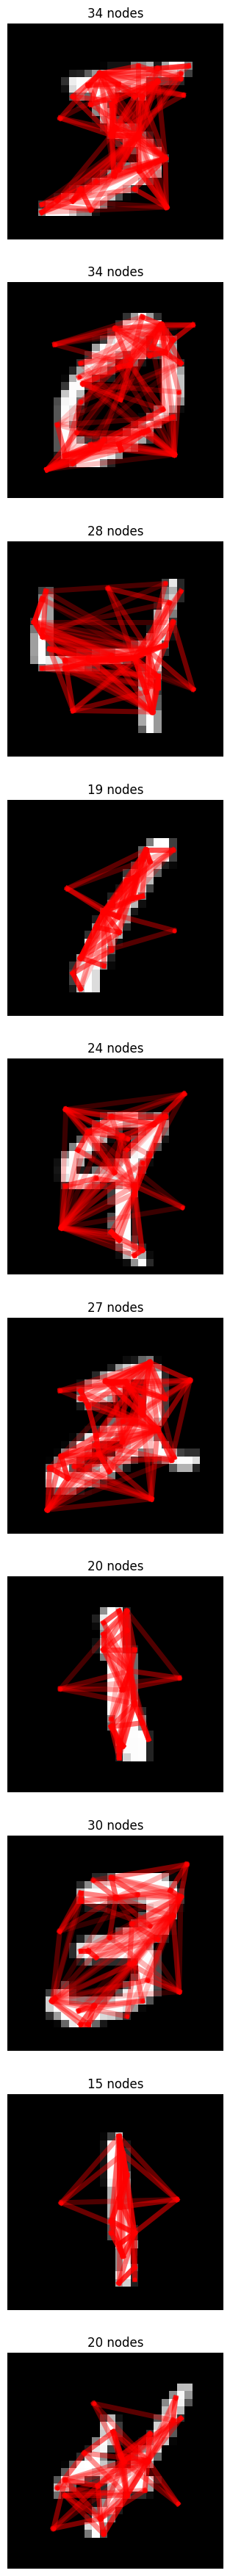

In [4]:
from shared.img_to_graph import img_to_graph
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 1, figsize=(15, 45))

for i in range(10):
    X, edge_index, edge_weights, centroids = img_to_graph(x_train[i])

    axs[i].imshow(x_train[i], cmap='gray')
    axs[i].scatter(centroids[:, 1], centroids[:, 0], color='red', s=10,)
    

    for idx, w in zip(edge_index, edge_weights):
        w = w.item()
        if w < 0:
            w = 0
        elif w > 1:
            w = 1

        start = centroids[idx[0], :]
        end = centroids[idx[1], :]
        axs[i].plot(
            [start[1], end[1]],
            [start[0], end[0]],
            color=(1, 0, 0, w),  
            linewidth=5
        )

    print(f"Avg w: {edge_weights.mean().item():.2f}, Max w: {edge_weights.max().item():.2f}, Min w: {edge_weights.min().item():.2f}")

    axs[i].set_title(f"{len(centroids)} nodes")
    axs[i].axis('off')